# Install required Python libraries for the project

This cell installs essential Python libraries: `pandas` for data manipulation, `scikit-learn` for machine learning tools, `matplotlib` for visualizations, `joblib` for saving/loading models, and `numpy`. These libraries are crucial for handling data, building models, and evaluating results. Running this cell ensures all dependencies are installed for the project.



In [1]:
!pip install pandas scikit-learn matplotlib joblib numpy pandas scipy matplotlib seaborn


# Importing Libraries
This cell imports the necessary libraries for building, training, evaluating, and saving a machine learning model using Python. It utilizes `pandas` for data manipulation, and `scikit-learn` modules such as `train_test_split` from `model_selection` to split datasets, `RandomForestClassifier` from `ensemble` for classification tasks, and evaluation metrics like `accuracy_score`, `classification_report`, and `confusion_matrix` from `metrics` to assess model performance. The `preprocessing` module provides tools like `StandardScaler` for feature scaling, `OneHotEncoder` for categorical encoding, and `ColumnTransformer` to apply transformations to specific columns, while `SimpleImputer` from `impute` handles missing values. The `Pipeline` utility is used to create a sequence of preprocessing and model training steps. `scipy.stats` includes the `zscore` function to detect outliers, and `numpy` assists with numerical operations. For visualization, `matplotlib.pyplot` and `seaborn` generate plots for data analysis. Finally, `joblib` is used to save and load the trained model. This combination of libraries supports end-to-end machine learning workflows, from data preprocessing to model persistence.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load and Inspect the Data:

The next few cells load and read the loan, payment, and test datasets from CSV files using pandas and outputs the shape of each dataset to get an overview of their dimensions as well as output their head. The `.shape` attribute is used to return the number of rows and columns for each dataset. This is helpful for understanding the size and structure of the data before performing further operations.

In [3]:
# Load data from CSV files
loan_data: pd.DataFrame = pd.read_csv('../data/train_loan_data.csv')
payment_data: pd.DataFrame = pd.read_csv('../data/train_payment_data.csv')
test_data: pd.DataFrame = pd.read_csv('../data/test_loan_data.csv')

# Print the shape (rows, columns) of each dataset
print(f"Loan Data Shape: {loan_data.shape}")
print(f"Payment Data Shape: {payment_data.shape}")
print(f"Test Data Shape: {test_data.shape}")


Loan Data Shape: (25102, 17)
Payment Data Shape: (83275, 4)
Test Data Shape: (2000, 18)


In [4]:
# Preview the data
loan_data.head()


,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
0,860706,604923,131449.0,NaN,Friend,Beauty Fashion,300000.0,345500.0,1,1,1.0,1.0,Approved,False,345500.0,345500.0,45500.0
1,975605,604923,131449.0,NaN,Friend,Beauty Fashion,330000.0,380000.0,2,2,2.0,1.0,Approved,False,380000.0,380000.0,50000.0
2,126416,122438,NaN,Client does not have all of the requirements,Friend,Food Staple Goods,300000.0,NaN,1,1,NaN,1.0,Declined,False,NaN,NaN,NaN
3,127617,122438,108019.0,NaN,Friend,Food Staple Goods,200000.0,221100.0,2,1,1.0,1.0,Approved,False,221100.0,221100.0,21100.0
4,148416,122438,108019.0,NaN,Friend,Food Staple Goods,220000.0,243200.0,3,2,2.0,1.0,Approved,False,243200.0,243200.0,23200.0


In [5]:
payment_data.head()


,loan_id,paid_at,amount,transaction_type
0,834148,2023-11-25 17:44,200000.0,Deposit
1,4028,2019-02-09 16:55,1036300.0,NaN
2,4798,2019-04-25 15:50,1228500.0,NaN
3,2082,2018-08-22 10:41,50000.0,NaN
4,3802,2019-01-05 16:00,1384600.0,NaN


In [6]:
test_data.head()

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,payment_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
0,1003730,604923,131449,NaN,Friend,Beauty Fashion,350000.0,399500.0,3,3,3,1.0,Approved,Paid up,False,399500.0,399500.0,49500.0
1,986527,122438,279289,NaN,Friend,Food Staple Goods,1500000.0,1771000.0,30,27,27,1.0,Approved,Paid up,False,1771000.0,1771000.0,271000.0
2,985254,675619,279290,NaN,Sales Team,Metal and Woodworking,578400.0,648400.0,2,2,2,NaN,Approved,Paid up,False,648400.0,648400.0,70000.0
3,989887,312482,108022,NaN,Friend,Mobile Money Airtime,650000.0,768300.0,20,19,19,1.0,Approved,Written off,True,0.0,0.0,-650000.0
4,994582,654630,137987,NaN,Friend,Hospitality,594000.0,665900.0,3,3,3,NaN,Approved,Paid up,False,665900.0,665900.0,71900.0


The following cell performs the following steps:

- **Merge Data**: Combines `loan_data` and `payment_data` on the `loan_id` column using a left join.
- **Handle Missing Values**:
  - Fills missing numerical values with the column mean.
  - Fills missing categorical values with the column mode.
- **Remove Duplicates**: Eliminates duplicate rows, keeping the first occurrence.
- **Display Results**: Prints the shape of the cleaned data and displays the first few rows for review.

In [7]:
# Merge loan and payment data
merged_data = pd.merge(loan_data, payment_data, on='loan_id', how='left')

# Handle missing values by filling numerical columns with mean and categorical columns with mode
numerical_cols = merged_data.select_dtypes(include=[np.number]).columns.tolist()
merged_data[numerical_cols] = merged_data[numerical_cols].fillna(merged_data[numerical_cols].mean())

categorical_cols = merged_data.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    merged_data[col] = merged_data[col].fillna(merged_data[col].mode()[0])

# Remove duplicates based on all columns (keeping the first occurrence)
merged_data = merged_data.drop_duplicates()

print(f"Data after removing duplicates: {merged_data.shape}")
merged_data.head()


Data after removing duplicates: (84311, 20)


,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd,paid_at,amount,transaction_type
0,860706,604923,131449.000000,Expired,Friend,Beauty Fashion,300000.0,345500.000000,1,1,1.000000,1.0,Approved,False,345500.000000,345500.000000,45500.000000,2023-11-24 15:33,15000.000000,Discount
1,860706,604923,131449.000000,Expired,Friend,Beauty Fashion,300000.0,345500.000000,1,1,1.000000,1.0,Approved,False,345500.000000,345500.000000,45500.000000,2023-12-28 11:51,330500.000000,Deposit
2,975605,604923,131449.000000,Expired,Friend,Beauty Fashion,330000.0,380000.000000,2,2,2.000000,1.0,Approved,False,380000.000000,380000.000000,50000.000000,2024-03-21 12:10,30000.000000,Discount
3,975605,604923,131449.000000,Expired,Friend,Beauty Fashion,330000.0,380000.000000,2,2,2.000000,1.0,Approved,False,380000.000000,380000.000000,50000.000000,2024-04-19 10:11,350000.000000,Deposit
4,126416,122438,187344.353902,Client does not have all of the requirements,Friend,Food Staple Goods,300000.0,964809.576171,1,1,10.438045,1.0,Declined,False,950193.090029,963374.122065,106237.542595,2024-02-05 08:55,219808.388391,Deposit


# Correlation Matrix Analysis

The following cell creates a **Correlation Matrix** for the numbers in the dataset:

1. It picks out important number-based columns like `principal`, `total_owing_at_issue`, and `employee_count`, ignoring text or ID columns.
2. Then, it calculates how much these numbers are related to each other. This helps to see if any two features behave similarly or are strongly connected.
3. A **heatmap** is made to show these relationships visually. In this map, you can easily see how close or far the numbers are connected (with values between -1 and 1).

This process helps to figure out which features might be too similar, allowing us to pick only the most useful ones for building the model.


I used a correlation matrix to provide a quick overview of the data,
helping me understand how different features relate to one another and
uncover trends and insights during Exploratory Data Analysis (EDA).
This approach guided the direction for further analysis and informed feature
selection for model development.

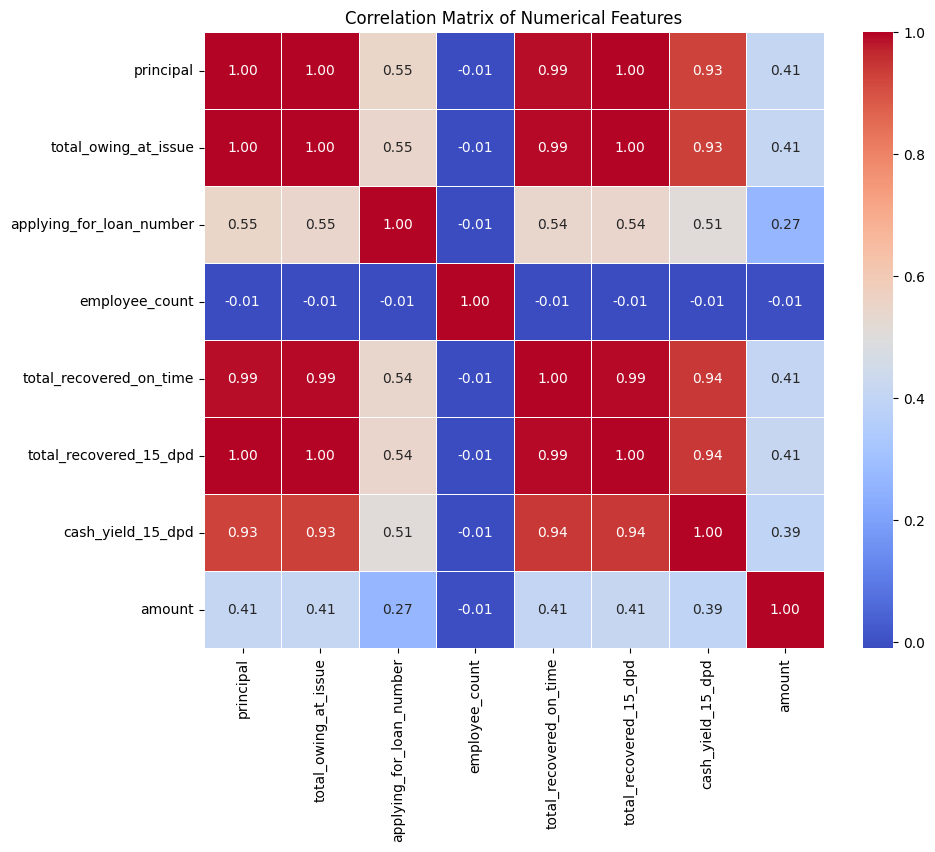

In [8]:
# Select only the relevant numeric columns for correlation matrix
numeric_cols = ['principal', 'total_owing_at_issue', 'applying_for_loan_number', 'employee_count',
                'total_recovered_on_time', 'total_recovered_15_dpd', 'cash_yield_15_dpd', 'amount']

# Compute the correlation matrix
correlation_matrix = merged_data[numeric_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# covariance_matrix = merged_data[numeric_cols].cov()
# sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Covariance Matrix of Numerical Features')
# plt.show()




# Feature Engineering:

The cell below is for performing feature engineering on the loan and payment data. First, it fills any missing amounts in the `payment_data` with `0`. Then, it calculates the total payments made for each loan and how many times payments were made for each loan (payment frequency). To avoid any problems while merging, it removes any existing `total_payments` and `payment_frequency` columns from the `merged_data` dataset. After that, it merges the newly calculated total payments and payment frequency back into the main loan dataset. It fills any remaining missing values in these new columns with `0`. Lastly, it drops a few unnecessary or highly correlated columns, and the updated dataset is printed to check that everything looks correct.

In [9]:
# Fill missing values in the 'amount' column of the payment data
payment_data['amount'] = payment_data['amount'].fillna(0)

# Calculate total payments made for each loan by summing up 'amount' for each 'loan_id'
total_payments = payment_data.groupby('loan_id')['amount'].sum().reset_index()
total_payments.rename(columns={'amount': 'total_payments'}, inplace=True)

# Calculate the frequency of payments made for each loan (how many times payments were made)
payment_frequency = payment_data.groupby('loan_id')['amount'].count().reset_index()
payment_frequency.rename(columns={'amount': 'payment_frequency'}, inplace=True)

# Drop 'total_payments' and 'payment_frequency' from merged_data if they already exist to avoid merge conflicts
if 'total_payments' in merged_data.columns:
    merged_data = merged_data.drop(columns=['total_payments'])

if 'payment_frequency' in merged_data.columns:
    merged_data = merged_data.drop(columns=['payment_frequency'])

# Merge the total_payments and payment_frequency back into the merged_data (main loan dataset)
merged_data = pd.merge(merged_data, total_payments, on='loan_id', how='left')
merged_data = pd.merge(merged_data, payment_frequency, on='loan_id', how='left')

# Fill any remaining missing values in the new features ('total_payments' and 'payment_frequency')
merged_data['total_payments'] = merged_data['total_payments'].fillna(0)
merged_data['payment_frequency'] = merged_data['payment_frequency'].fillna(0)

# Drop highly correlated features that won't be used (based on correlation matrix analysis)
columns_to_drop = ['total_recovered_15_dpd', 'application_number', 'loan_number']
merged_data = merged_data.drop(columns=[col for col in columns_to_drop if col in merged_data.columns], axis=1)

# Display the updated dataframe to ensure everything looks correct
print("Final Merged Data:")
merged_data.head()


Final Merged Data:


,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,applying_for_loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,cash_yield_15_dpd,paid_at,amount,transaction_type,total_payments,payment_frequency
0,860706,604923,131449.000000,Expired,Friend,Beauty Fashion,300000.0,345500.000000,1,1.0,Approved,False,345500.000000,45500.000000,2023-11-24 15:33,15000.000000,Discount,345500.0,2.0
1,860706,604923,131449.000000,Expired,Friend,Beauty Fashion,300000.0,345500.000000,1,1.0,Approved,False,345500.000000,45500.000000,2023-12-28 11:51,330500.000000,Deposit,345500.0,2.0
2,975605,604923,131449.000000,Expired,Friend,Beauty Fashion,330000.0,380000.000000,2,1.0,Approved,False,380000.000000,50000.000000,2024-03-21 12:10,30000.000000,Discount,380000.0,2.0
3,975605,604923,131449.000000,Expired,Friend,Beauty Fashion,330000.0,380000.000000,2,1.0,Approved,False,380000.000000,50000.000000,2024-04-19 10:11,350000.000000,Deposit,380000.0,2.0
4,126416,122438,187344.353902,Client does not have all of the requirements,Friend,Food Staple Goods,300000.0,964809.576171,1,1.0,Declined,False,950193.090029,106237.542595,2024-02-05 08:55,219808.388391,Deposit,0.0,0.0


The cell below is for creating **boxplots** to detect outliers in the numerical features of the dataset for both good-performing and bad-performing loans. These features include:

- `principal`: The loan's principal amount.
- `total_owing_at_issue`: The total amount owed when the loan was issued.
- `total_payments`: The total payments made towards the loan.
- `cash_yield_15_dpd`: Cash yield for loans that are 15 days past due.
- `amount`: The transaction amount related to the loan.

The boxplots illustrate the distribution of values for each feature, where the **boxes** represent the middle 50% of the data (the interquartile range). The **whiskers** extending from the boxes indicate the range of most of the data, while **outliers** (individual points above or below the whiskers) show values significantly different from the rest of the data. By comparing good and bad performing loans, this analysis helps identify extreme values or patterns that may impact the model's performance and require special handling.

Index(['loan_id', 'business_id', 'credit_officer_id', 'dismissal_description',
       'acquisition_channel', 'sector', 'principal', 'total_owing_at_issue',
       'applying_for_loan_number', 'employee_count', 'approval_status',
       'paid_late', 'total_recovered_on_time', 'cash_yield_15_dpd', 'paid_at',
       'amount', 'transaction_type', 'total_payments', 'payment_frequency'],
      dtype='object')


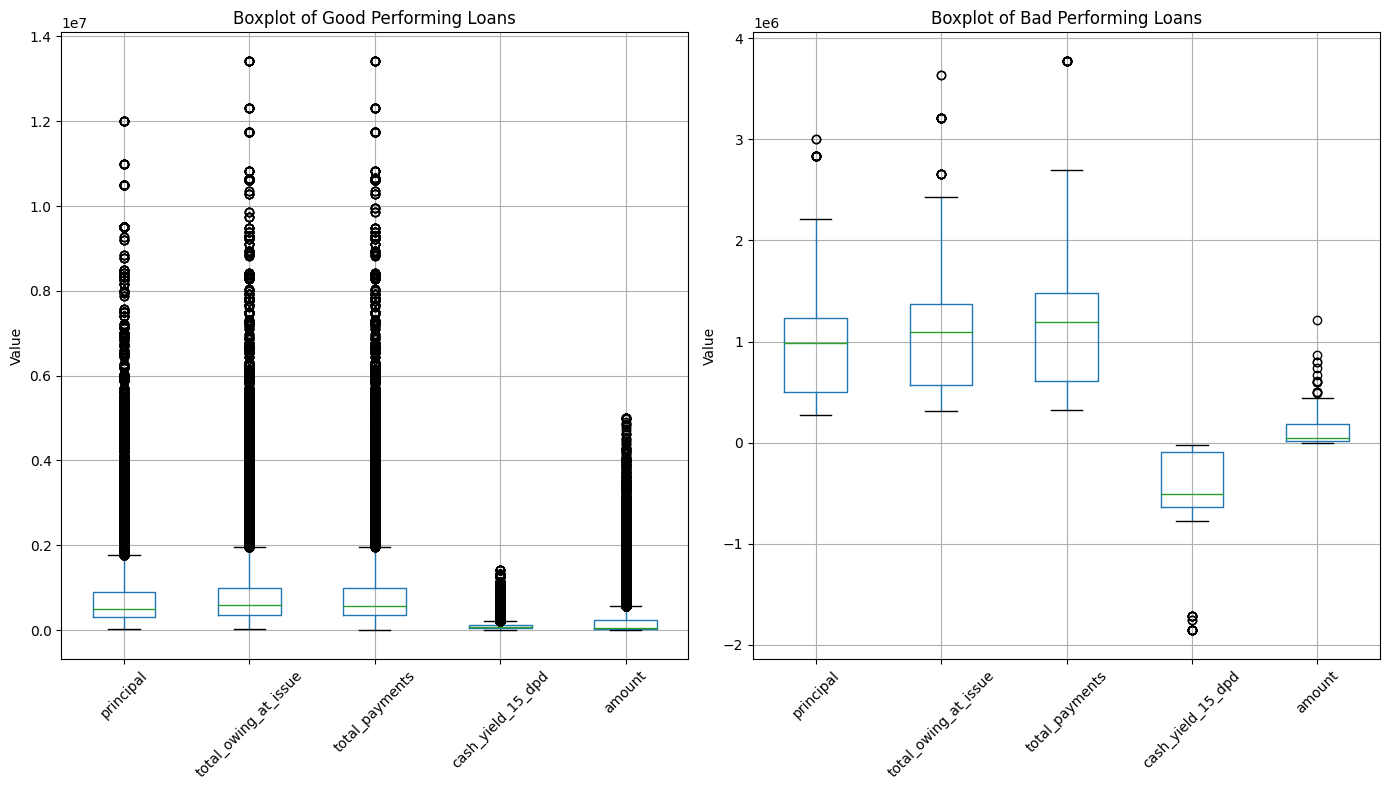

In [10]:
# Check if 'loan_performance' exists in the dataset
print(merged_data.columns)

# If 'loan_performance' doesn't exist, create it
if 'loan_performance' not in merged_data.columns:
    merged_data['loan_performance'] = np.where(
        (merged_data['paid_late'] == False) | (merged_data['cash_yield_15_dpd'] > 0), 1, 0
    )

# Select only the numerical columns for analysis
numeric_columns = ['principal', 'total_owing_at_issue', 'total_payments', 'cash_yield_15_dpd', 'amount']

# Split the data into two groups based on loan performance
good_performance = merged_data[merged_data['loan_performance'] == 1]
bad_performance = merged_data[merged_data['loan_performance'] == 0]

# Plot the boxplots for both good and bad performing loans
plt.figure(figsize=(14, 8))

# Boxplot for Good Performing Loans
plt.subplot(1, 2, 1)
good_performance[numeric_columns].boxplot()
plt.title('Boxplot of Good Performing Loans')
plt.xticks(rotation=45)
plt.ylabel('Value')

# Boxplot for Bad Performing Loans
plt.subplot(1, 2, 2)
bad_performance[numeric_columns].boxplot()
plt.title('Boxplot of Bad Performing Loans')
plt.xticks(rotation=45)
plt.ylabel('Value')

plt.tight_layout()
plt.show()

# The distributions suggest that models robust to outliers, such as Random Forest
# or Gradient Boosting, may perform better than models sensitive to extreme values,
# like linear regression as well as it will dictate that we do clusterning to group similar loans and identification of loans in their different clusters


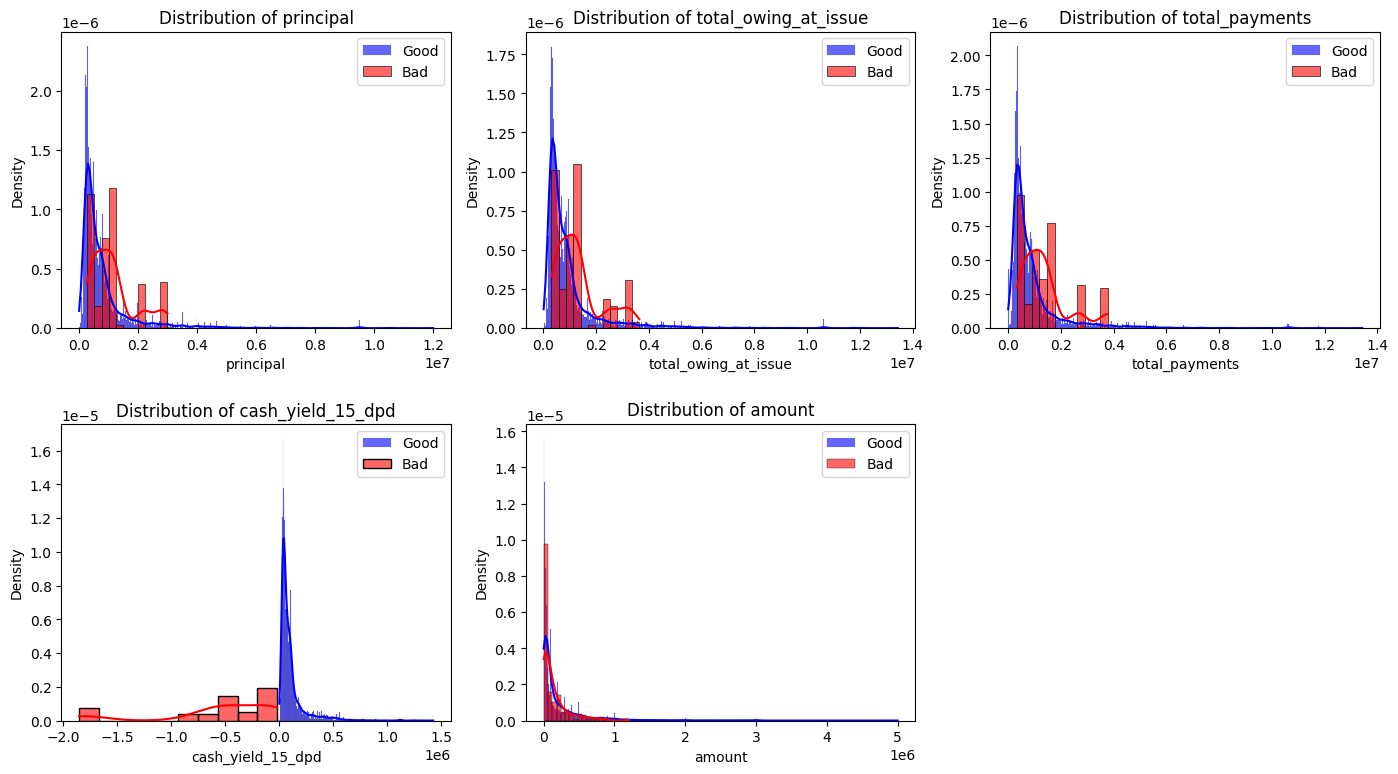

In [11]:
plt.figure(figsize=(14, 8))

for i, col in enumerate(numeric_columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(good_performance[col], color='blue', label='Good', kde=True, stat='density', alpha=0.6)
    sns.histplot(bad_performance[col], color='red', label='Bad', kde=True, stat='density', alpha=0.6)
    plt.title(f'Distribution of {col}')
    plt.legend()

plt.tight_layout()
plt.show()

The cell below is to demonstrate how the loans are performing in the four areas listed below:

1. **Loans by Business Sector**:
   - Most sectors, like "Beauty Fashion" and "Food Staple Goods", have a lot of good loans (green), with very few bad ones (red).

2. **Loans by Acquisition Channel**:
   - Loans acquired through "Friend" and "Facebook" have the most good loans, with very few bad ones.

3. **Loans by Amount Range**:
   - Smaller loans (0-100k) perform best, with very few bad loans across all ranges.

4. **Loans by Repayment Cycle**:
   - Loans with fewer repayments (0-5) have the most good loans, and bad loans are rare across all repayment cycles.

These charts help understand which factors lead to better loan performance.

<ipython-input-12-29ec94152865>:81: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  loan_performance_pivot_repayment = loan_performance_by_repayment.pivot_table(index='repayment_cycle_batch', columns='loan_performance', values='loan_count').fillna(0)


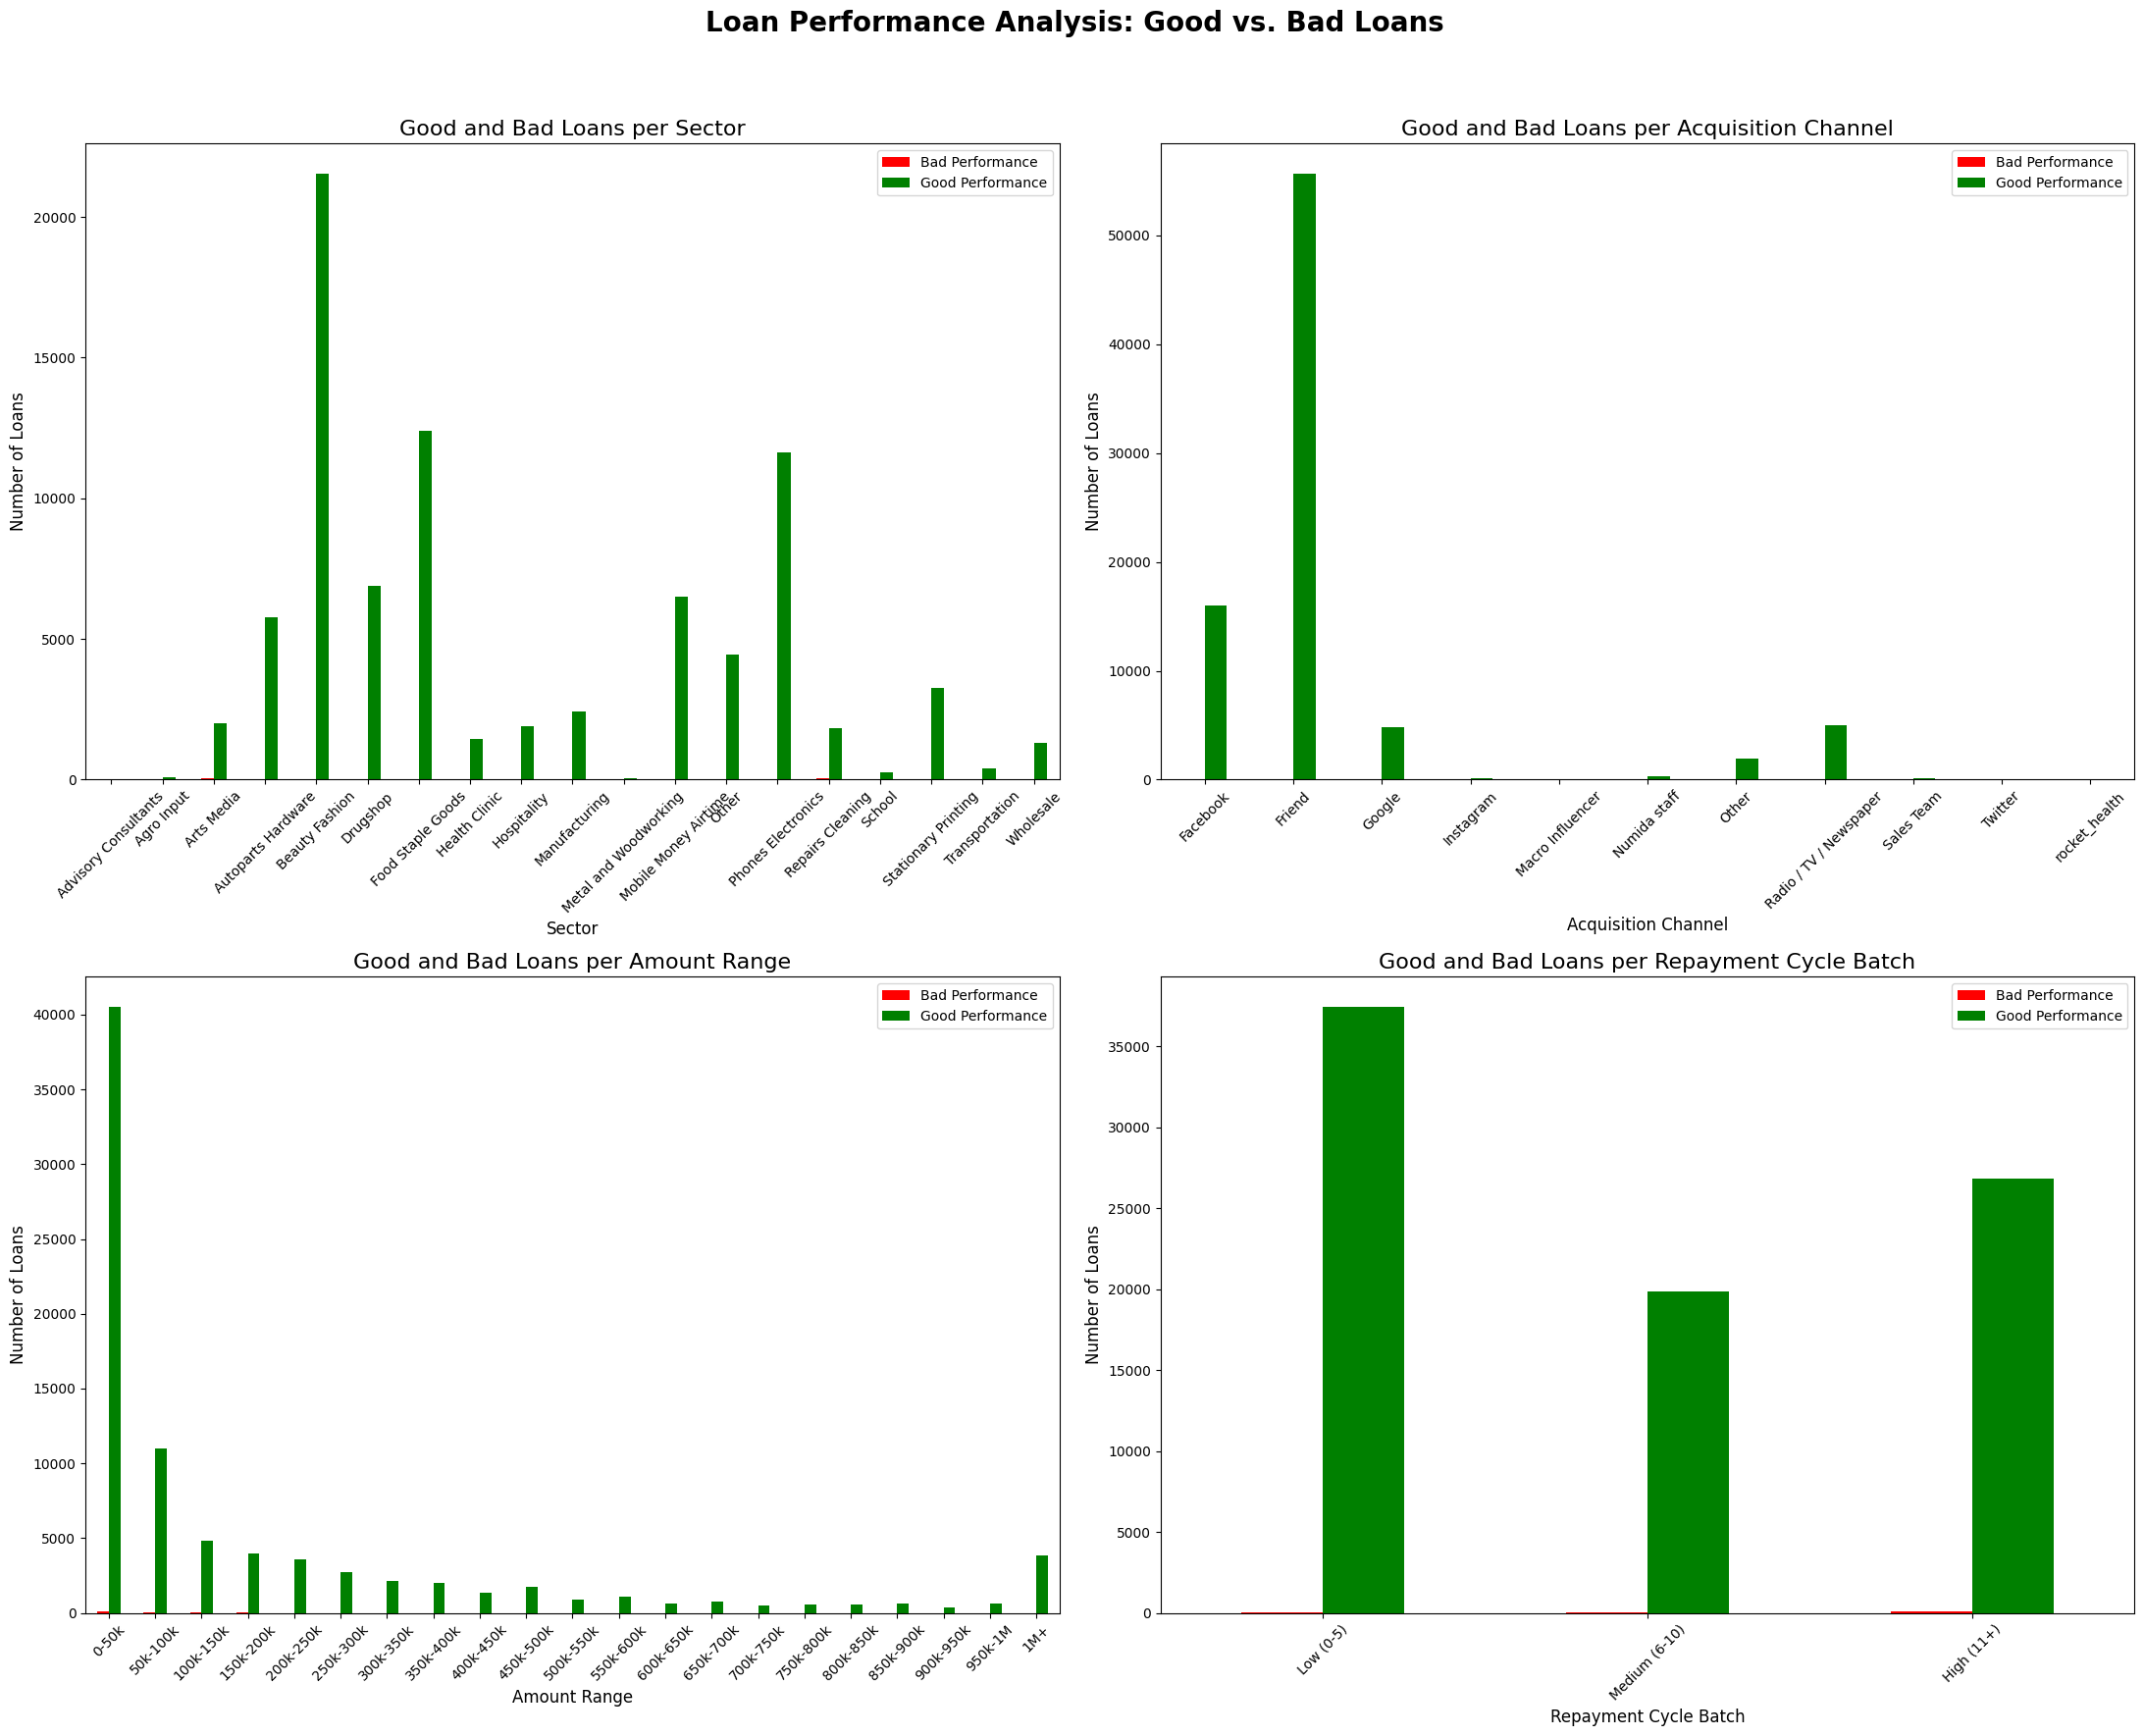

In [12]:
# Set the size of the entire figure and create a grid of 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(22, 18))  # Increased figure size

# First Plot: Good and Bad Loans per Sector
loan_performance_by_sector = merged_data.groupby(['sector', 'loan_performance']).size().reset_index(name='loan_count')
loan_performance_pivot = loan_performance_by_sector.pivot(index='sector', columns='loan_performance', values='loan_count').fillna(0)
loan_performance_pivot.columns = ['Bad Performance', 'Good Performance']

loan_performance_pivot[['Bad Performance', 'Good Performance']].plot(
    kind='bar',
    stacked=False,
    ax=axes[0, 0],  # Plot on the first subplot
    color=['red', 'green']
)
axes[0, 0].set_title('Good and Bad Loans per Sector', fontsize=16)
axes[0, 0].set_xlabel('Sector', fontsize=12)
axes[0, 0].set_ylabel('Number of Loans', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)

# Second Plot: Good and Bad Loans per Acquisition Channel
loan_performance_by_acquisition = merged_data.groupby(['acquisition_channel', 'loan_performance']).size().reset_index(name='loan_count')
loan_performance_acquisition_pivot = loan_performance_by_acquisition.pivot(index='acquisition_channel', columns='loan_performance', values='loan_count').fillna(0)
loan_performance_acquisition_pivot.columns = ['Bad Performance', 'Good Performance']

loan_performance_acquisition_pivot.plot(
    kind='bar',
    stacked=False,
    ax=axes[0, 1],  # Plot on the second subplot
    color=['red', 'green']
)
axes[0, 1].set_title('Good and Bad Loans per Acquisition Channel', fontsize=16)
axes[0, 1].set_xlabel('Acquisition Channel', fontsize=12)
axes[0, 1].set_ylabel('Number of Loans', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)


# Define new bins for 50k increments and beyond 1M
amount_bins = [
    0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000,
    450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000,
    850000, 900000, 950000, 1000000, float('inf')
               ]

amount_labels = [
    '0-50k', '50k-100k', '100k-150k', '150k-200k', '200k-250k',
    '250k-300k', '300k-350k', '350k-400k', '400k-450k', '450k-500k',
    '500k-550k', '550k-600k', '600k-650k', '650k-700k', '700k-750k',
    '750k-800k', '800k-850k', '850k-900k', '900k-950k', '950k-1M', '1M+'
    ]

# Create a new column for amount ranges using the new bins
merged_data['amount_range'] = pd.cut(merged_data['amount'], bins=amount_bins, labels=amount_labels, include_lowest=True)

# Display the first few rows to ensure everything looks correct
merged_data[['amount', 'amount_range']].head()



merged_data.loc[:, 'amount_range'] = pd.cut(merged_data['amount'], bins=amount_bins, labels=amount_labels, include_lowest=True)
loan_performance_by_amount = merged_data.groupby(['amount_range', 'loan_performance'], observed=True).size().reset_index(name='loan_count')
loan_performance_amount_pivot = loan_performance_by_amount.pivot(index='amount_range', columns='loan_performance', values='loan_count').fillna(0)
loan_performance_amount_pivot.columns = ['Bad Performance', 'Good Performance']

loan_performance_amount_pivot.plot(
    kind='bar',
    stacked=False,
    ax=axes[1, 0],  # Plot on the third subplot
    color=['red', 'green']
)
axes[1, 0].set_title('Good and Bad Loans per Amount Range', fontsize=16)
axes[1, 0].set_xlabel('Amount Range', fontsize=12)
axes[1, 0].set_ylabel('Number of Loans', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)

# --- Fourth Plot: Good and Bad Loans per Repayment Cycle Batch ---
repayment_bins = [0, 5, 10, float('inf')]  # Define repayment cycle bins
repayment_labels = ['Low (0-5)', 'Medium (6-10)', 'High (11+)']

merged_data['repayment_cycle_batch'] = pd.cut(merged_data['payment_frequency'], bins=repayment_bins, labels=repayment_labels, include_lowest=True)
loan_performance_by_repayment = merged_data.groupby(['repayment_cycle_batch', 'loan_performance'], observed=True).size().reset_index(name='loan_count')
loan_performance_pivot_repayment = loan_performance_by_repayment.pivot_table(index='repayment_cycle_batch', columns='loan_performance', values='loan_count').fillna(0)
loan_performance_pivot_repayment.columns = ['Bad Performance', 'Good Performance']

# No need to melt, we can plot directly using the pivoted data
loan_performance_pivot_repayment.plot(
    kind='bar',
    stacked=False,
    ax=axes[1, 1],  # Plot on the fourth subplot
    color=['red', 'green']
)
axes[1, 1].set_title('Good and Bad Loans per Repayment Cycle Batch', fontsize=16)
axes[1, 1].set_xlabel('Repayment Cycle Batch', fontsize=12)
axes[1, 1].set_ylabel('Number of Loans', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)

# --- Adjust layout and add a general title ---
fig.suptitle('Loan Performance Analysis: Good vs. Bad Loans', fontsize=20, weight='bold')  # Add a general title
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Increase space between plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the tight layout to fit the title
plt.show()


In [13]:
"""
Just a pointer, generally the data is skewed towards good-performing loans,
meaning that bad loans represent a smaller proportion of the dataset. Most loans perform well,
which can make it more challenging for models to learn the characteristics of bad loans.

"""

'\nJust a pointer, generally the data is skewed towards good-performing loans, \nmeaning that bad loans represent a smaller proportion of the dataset. Most loans perform well, \nwhich can make it more challenging for models to learn the characteristics of bad loans. \n\n'

# Z-Score Normalization

In the cell below we are using **Z-Score Outlier Detection** to identify extreme values in the data that may negatively impact the model. A Z-score greater than 3 indicates an outlier. Detecting and handling these outliers helps improve data quality and model accuracy by removing or adjusting values that are significantly different from the rest of the data. This process ensures the model is not overly influenced by unusual data points.

In [14]:
# Z-Score Outlier Detection for numeric columns
z_scores = np.abs(merged_data[numeric_columns].apply(zscore))

# Set a standard deveiation threshold of 3 to target the most extreeme values
standard_deviation_threshold = 3

# Count the number of outliers (Z-score > 3)
outliers = (z_scores > standard_deviation_threshold).sum()
print(f"Outliers detected (Z-score threshold 3):")
print(outliers)

# Filter rows that have any outliers in any column (Z-score > 3)
outliers_df = merged_data[(z_scores > standard_deviation_threshold).any(axis=1)]
outliers_df.head()


Outliers detected (Z-score threshold 3):
principal               2024
total_owing_at_issue    2024
total_payments          2022
cash_yield_15_dpd       2001
amount                  1933
dtype: int64


,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,applying_for_loan_number,employee_count,...,total_recovered_on_time,cash_yield_15_dpd,paid_at,amount,transaction_type,total_payments,payment_frequency,loan_performance,amount_range,repayment_cycle_batch
115,953103,122438,279289.0,Expired,Friend,Food Staple Goods,1350000.0,1594100.0,26,1.0,...,1594100.0,244100.0,2024-04-02 12:22,1594100.0,Deposit,1594100.0,1.0,1,1M+,Low (0-5)
164,927969,312482,108022.0,Expired,Friend,Mobile Money Airtime,723900.0,811300.0,18,1.0,...,0.0,-523900.0,2024-03-19 14:33,200000.0,Deposit,873900.0,2.0,0,150k-200k,Low (0-5)
165,927969,312482,108022.0,Expired,Friend,Mobile Money Airtime,723900.0,811300.0,18,1.0,...,0.0,-523900.0,2024-03-21 08:02,673900.0,Deposit,873900.0,2.0,0,650k-700k,Low (0-5)
228,920037,489901,137987.0,Expired,Friend,Phones Electronics,1530600.0,1713900.0,8,2.0,...,1713900.0,183300.0,2024-02-26 06:38,1713900.0,Deposit,1713900.0,1.0,1,1M+,Low (0-5)
229,950509,489901,57802.0,Expired,Friend,Phones Electronics,1607100.0,1799400.0,9,2.0,...,1799400.0,192300.0,2024-03-27 08:33,1799400.0,Deposit,1799400.0,1.0,1,1M+,Low (0-5)


# Dataset Preparation for Model Training

- **Loan Classification**: The goal is to classify loans into good and bad performance categories based on repayment behavior and other factors.
- **Data Preparation**: The code is categorizing loans into different ranges for amount and repayment frequency to facilitate easier analysis and model building later.
- **Data Cleaning**: Duplicates are removed to ensure the dataset is clean and ready for further processing.

In [15]:
# if the cash yield 15 days past due (DPD) is greater than 0, it is still considered to have good performance.
merged_data['loan_performance'] = np.where(
    (merged_data['paid_late'] == False) | (merged_data['cash_yield_15_dpd'] > 0), 1, 0
)

# Define amount ranges (already done in previous steps)
merged_data['amount_range'] = pd.cut(merged_data['amount'], bins=amount_bins, labels=amount_labels, include_lowest=True)

merged_data['total_payments_amount_range'] = pd.cut(merged_data['total_payments'], bins=amount_bins, labels=amount_labels, include_lowest=True)

# Define repayment cycle batches (already done in previous steps)
repayment_bins = [0, 5, 10, float('inf')]
repayment_labels = ['Low (0-5)', 'Medium (6-10)', 'High (11+)']
merged_data['repayment_cycle_batch'] = pd.cut(merged_data['payment_frequency'], bins=repayment_bins, labels=repayment_labels, include_lowest=True)


# Display the number of rows and columns after removing duplicates
print(f"Data shape after removing duplicates: {merged_data.shape}")

# Display the first few rows to ensure duplicates are removed
merged_data.head()

Data shape after removing duplicates: (84311, 23)


,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,applying_for_loan_number,employee_count,...,cash_yield_15_dpd,paid_at,amount,transaction_type,total_payments,payment_frequency,loan_performance,amount_range,repayment_cycle_batch,total_payments_amount_range
0,860706,604923,131449.000000,Expired,Friend,Beauty Fashion,300000.0,345500.000000,1,1.0,...,45500.000000,2023-11-24 15:33,15000.000000,Discount,345500.0,2.0,1,0-50k,Low (0-5),300k-350k
1,860706,604923,131449.000000,Expired,Friend,Beauty Fashion,300000.0,345500.000000,1,1.0,...,45500.000000,2023-12-28 11:51,330500.000000,Deposit,345500.0,2.0,1,300k-350k,Low (0-5),300k-350k
2,975605,604923,131449.000000,Expired,Friend,Beauty Fashion,330000.0,380000.000000,2,1.0,...,50000.000000,2024-03-21 12:10,30000.000000,Discount,380000.0,2.0,1,0-50k,Low (0-5),350k-400k
3,975605,604923,131449.000000,Expired,Friend,Beauty Fashion,330000.0,380000.000000,2,1.0,...,50000.000000,2024-04-19 10:11,350000.000000,Deposit,380000.0,2.0,1,300k-350k,Low (0-5),350k-400k
4,126416,122438,187344.353902,Client does not have all of the requirements,Friend,Food Staple Goods,300000.0,964809.576171,1,1.0,...,106237.542595,2024-02-05 08:55,219808.388391,Deposit,0.0,0.0,1,200k-250k,Low (0-5),0-50k


# Model Training

In [16]:
# Select features, excluding 'employee_count' and 'acquisition_channel', but including 'sector', 'amount_range', and 'repayment_cycle_batch'
X = merged_data[[ 'total_payments_amount_range', 'payment_frequency', 'sector', 'amount_range', 'repayment_cycle_batch']]

# Select the target column ('loan_performance')
y = merged_data['loan_performance']

X.head()


,total_payments_amount_range,payment_frequency,sector,amount_range,repayment_cycle_batch
0,300k-350k,2.0,Beauty Fashion,0-50k,Low (0-5)
1,300k-350k,2.0,Beauty Fashion,300k-350k,Low (0-5)
2,350k-400k,2.0,Beauty Fashion,0-50k,Low (0-5)
3,350k-400k,2.0,Beauty Fashion,300k-350k,Low (0-5)
4,0-50k,0.0,Food Staple Goods,200k-250k,Low (0-5)


In [17]:
# Train-test split (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline: Handle numeric and categorical features separately
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),    # Handle missing numeric values
    ('scaler', StandardScaler())                    # Scale numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode categorical features
])

# Combine preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['payment_frequency']),
        ('cat', categorical_transformer, ['sector', 'total_payments_amount_range', 'amount_range', 'repayment_cycle_batch'])
    ]
)

# Define the model pipeline (preprocessor + RandomForestClassifier)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
print("Training the model...")
clf.fit(X_train, y_train)
print("Model training completed")


Training the model...
Model training completed


# Model Evaluation: Feature Importance

Validation Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.73        30
           1       1.00      1.00      1.00     16833

    accuracy                           1.00     16863
   macro avg       0.97      0.80      0.87     16863
weighted avg       1.00      1.00      1.00     16863



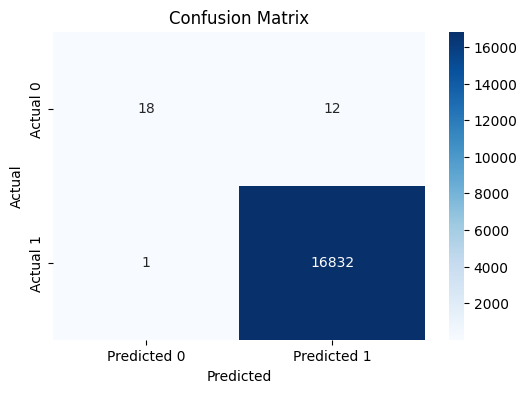

In [18]:
# Make predictions on the validation set
y_pred = clf.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix to visualize prediction results
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [19]:
"""

From the results above in the confusion matrix, it is clear that the model has a high accuracy
when predicting good loans, but it doesn't quite capture bad loans.

TP = 16,832
TN = 18
FP = 12
FN = 1

it seems like the model has very few instances of bad loans,
 while most of the loans are predicted as good loans.

This confirms that class imbalance is likely affecting the model’s performance,
particularly in terms of correctly predicting bad loans.
"""

"\n\nFrom the results above in the confusion matrix, it is clear that the model has a high accuracy \nwhen predicting good loans, but it doesn't quite capture bad loans.\n\nTP = 16,832  \nTN = 18             \nFP = 12\nFN = 1           \n\nit seems like the model has very few instances of bad loans,\n while most of the loans are predicted as good loans. \n\nThis confirms that class imbalance is likely affecting the model’s performance, \nparticularly in terms of correctly predicting bad loans.\n"

# Save the trained model

In [20]:

joblib.dump(clf, 'loan_performance_model.pkl')
print("Model saved to 'loan_performance_model.pkl'")


Model saved to 'loan_performance_model.pkl'


In [21]:
# Merge payment data into the test dataset to get the 'amount' column if it's missing
if 'amount' not in test_data.columns:
    test_data = pd.merge(test_data, payment_data[['loan_id', 'amount']], on='loan_id', how='left')

# Now, ensure 'amount' is present and has been merged
print(f"test_data after merging 'amount': \n{test_data[['loan_id', 'amount']].head()}")

# Continue processing as before
test_data['amount'] = test_data['amount'].fillna(0)

# Calculate total payments for each loan_id and merge it into test_data
print("Calculating total payments...")
test_total_payments = payment_data.groupby('loan_id')['amount'].sum().reset_index()
test_total_payments.rename(columns={'amount': 'total_payments'}, inplace=True)

# Merge total payments with test_data
test_data = pd.merge(test_data, test_total_payments, on='loan_id', how='left')

# Calculate payment frequency (how many times payments were made for each loan) and merge into test_data
print("Calculating payment frequency...")
test_payment_frequency = payment_data.groupby('loan_id')['amount'].count().reset_index()
test_payment_frequency.rename(columns={'amount': 'payment_frequency'}, inplace=True)

# Print to check if payment frequency is calculated correctly
print(f"Payment Frequency: \n{test_payment_frequency.head()}")

# Drop existing 'payment_frequency' in test_data to avoid conflicts during the merge
if 'payment_frequency' in test_data.columns:
    test_data = test_data.drop(columns=['payment_frequency'])

# Merge the payment frequency data with the test_data
test_data = pd.merge(test_data, test_payment_frequency, on='loan_id', how='left')

# Ensure 'payment_frequency' exists and fill missing values if necessary
if 'payment_frequency' in test_data.columns:
    test_data['payment_frequency'] = test_data['payment_frequency'].fillna(0)
else:
    raise KeyError("'payment_frequency' column is still missing after the merge.")

# Create 'amount_range' based on predefined bins
test_data['amount_range'] = pd.cut(test_data['amount'], bins=amount_bins, labels=amount_labels, include_lowest=True)

# Create 'total_payments_amount_range' in test_data, not merged_data
test_data['total_payments_amount_range'] = pd.cut(test_data['total_payments'], bins=amount_bins, labels=amount_labels, include_lowest=True)

# Create 'repayment_cycle_batch' based on predefined bins
repayment_bins = [0, 5, 10, float('inf')]
repayment_labels = ['Low (0-5)', 'Medium (6-10)', 'High (11+)']
test_data['repayment_cycle_batch'] = pd.cut(test_data['payment_frequency'], bins=repayment_bins, labels=repayment_labels, include_lowest=True)

# Verify that all necessary columns exist before selecting features
expected_columns = ['principal', 'total_owing_at_issue', 'total_payments_amount_range', 'payment_frequency', 'sector', 'amount_range', 'repayment_cycle_batch']
missing_columns = [col for col in expected_columns if col not in test_data.columns]

# if missing_columns:
#     raise KeyError(f"Missing columns in test_data: {missing_columns}")

# Select features for the test set, including 'amount_range' and 'repayment_cycle_batch'
X_test = test_data[['principal', 'total_owing_at_issue', 'total_payments_amount_range', 'payment_frequency', 'sector', 'amount_range', 'repayment_cycle_batch']]

# Make predictions on the test data
test_predictions = clf.predict(X_test)
test_data['predicted_performance'] = test_predictions

# Display the first few rows of the test data with predictions
test_data[['loan_id', 'principal', 'total_owing_at_issue', 'predicted_performance']].head()


test_data after merging 'amount': 
   loan_id  amount
0  1003730     NaN
1   986527     NaN
2   985254     NaN
3   989887     NaN
4   994582     NaN
Calculating total payments...
Calculating payment frequency...
Payment Frequency: 
   loan_id  payment_frequency
0      619                  8
1     1222                  6
2     1308                  3
3     1432                  3
4     1540                  4


,loan_id,principal,total_owing_at_issue,predicted_performance
0,1003730,350000.0,399500.0,1
1,986527,1500000.0,1771000.0,1
2,985254,578400.0,648400.0,1
3,989887,650000.0,768300.0,1
4,994582,594000.0,665900.0,1


# Correlation Heatmap for Test Data
You can generate a correlation heatmap of key numerical features in the test data to see how the model’s features and predictions relate to each other.

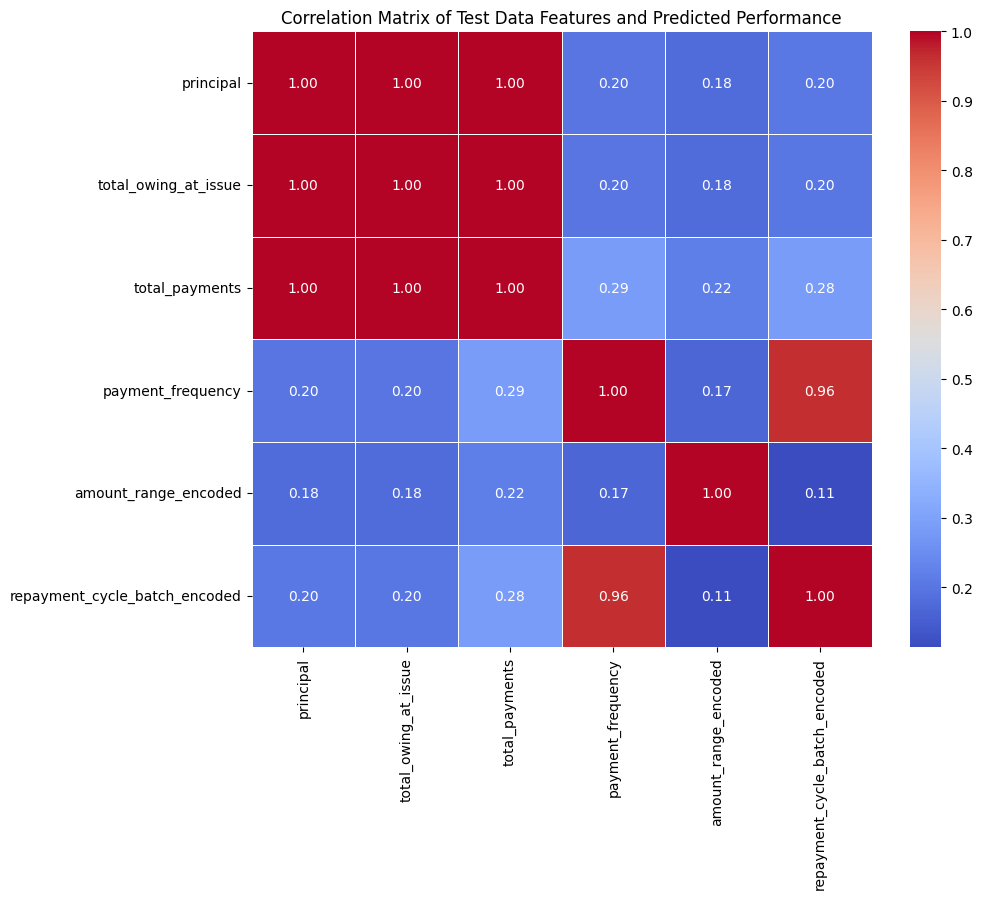

In [22]:
# Ensure 'amount_range' and 'repayment_cycle_batch' are properly converted to categorical before encoding
test_data['amount_range'] = pd.Categorical(test_data['amount_range'], categories=amount_labels)
test_data['repayment_cycle_batch'] = pd.Categorical(test_data['repayment_cycle_batch'], categories=repayment_labels)

# Convert 'amount_range' and 'repayment_cycle_batch' to encoded integer values
test_data['amount_range_encoded'] = test_data['amount_range'].cat.codes
test_data['repayment_cycle_batch_encoded'] = test_data['repayment_cycle_batch'].cat.codes

# Select relevant numeric columns, including the encoded categories and predicted performance
correlation_columns = [
    'principal', 'total_owing_at_issue', 'total_payments', 'payment_frequency',
    'amount_range_encoded', 'repayment_cycle_batch_encoded'
]

# Check if all required columns exist in test_data
missing_columns = [col for col in correlation_columns if col not in test_data.columns]
if missing_columns:
    raise KeyError(f"The following columns are missing from the test data: {missing_columns}")

# Ensure all data is numeric for correlation calculation
test_data[correlation_columns] = test_data[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Compute the correlation matrix
correlation = test_data[correlation_columns].corr()

# Plot the updated correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Test Data Features and Predicted Performance')
plt.show()
